In [28]:
import torch
import numpy as np
import math
from torch import nn

In [29]:
max_degree = 20
n_train,n_test = 100,100

true_w = np.zeros(max_degree)

In [30]:
# according to exercise
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))

In [31]:
np.random.shuffle(features)

In [32]:
np.arange(max_degree).reshape(1,-1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [33]:
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

In [34]:
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # gamma is (n-1)!

In [35]:
labels = np.dot( poly_features, true_w)
labels.shape

(200,)

In [36]:
min(labels), max(labels)

(-61.0886554695634, 8.870571215786708)

In [37]:
# adding epsilon noise
labels += np.random.normal(scale=0.1, size=labels.shape)

# what we generated was

# y = 5 + 1.2 * x  - 3.4 * x^2/2! + 5.6 * x^3/3! + epsilon 

In [38]:
# converting to tensor
true_w,features,poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [39]:
features[:2], poly_features[:2,:], labels[:2]

(tensor([[ 0.7222],
         [-2.0626]]),
 tensor([[ 1.0000e+00,  7.2216e-01,  2.6076e-01,  6.2769e-02,  1.1332e-02,
           1.6367e-03,  1.9700e-04,  2.0323e-05,  1.8346e-06,  1.4721e-07,
           1.0631e-08,  6.9791e-10,  4.2000e-11,  2.3331e-12,  1.2035e-13,
           5.7940e-15,  2.6151e-16,  1.1109e-17,  4.4569e-19,  1.6940e-20],
         [ 1.0000e+00, -2.0626e+00,  2.1272e+00, -1.4626e+00,  7.5420e-01,
          -3.1113e-01,  1.0696e-01, -3.1516e-02,  8.1259e-03, -1.8623e-03,
           3.8413e-04, -7.2029e-05,  1.2381e-05, -1.9644e-06,  2.8942e-07,
          -3.9798e-08,  5.1305e-09, -6.2250e-10,  7.1333e-11, -7.7439e-12]]),
 tensor([  5.2079, -12.8312]))

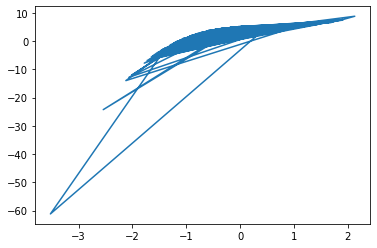

In [40]:
import  matplotlib.pyplot as plt

plt.plot(features, labels)

# complex polynomial

In [41]:
def evaluate_loss(net, data_iter, loss):
    total_loss = 0
    total_len = 0
    for X,y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat)
        l = loss(y_hat, y)
        total_loss += l
        total_len += l.numel()
    
    return total_loss/total_len
        

In [42]:
class simpleDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
        self.featres = self.features.type(torch.FloatTensor)
        self.labels = self.labels.type(torch.FloatTensor)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

train_dataset = simpleDataset(features[:n_train], labels[:n_train].reshape(-1,1))

X, y = train_dataset[0]

print(X)
print(y)
    

tensor([0.7222])
tensor([5.2079])


In [43]:
def create_iter(features, labels, batch_size):
    return torch.utils.data.DataLoader(simpleDataset(features, labels), shuffle=True, batch_size=batch_size)

In [44]:
sample_iter = create_iter(features[:n_train], labels[:n_train], 10)

for X,y in sample_iter:
    print(X.shape, y.shape)
    break

torch.Size([10, 1]) torch.Size([10])


In [45]:
def evaluate_loss(net, data_iter, loss, text):
    total_loss = 0
    total_number = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l =  loss(y_hat, y)
            total_loss += l
            total_number += y.numel()
#     print(f"{text} loss is : {total_loss/total_number}")
    return total_loss/total_number

In [46]:

def train(train_features, train_labels, test_features, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    print(f"input feature size is : {input_shape}")
    net = nn.Sequential(nn.Linear(input_shape,1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = create_iter(train_features, train_labels.reshape(-1,1), batch_size)
    test_iter = create_iter(test_features, test_labels.reshape(-1,1), batch_size)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    # training loop
    train_loss_array = []
    test_loss_array = []
    epoch_number = []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X)
#             print(y_hat.shape)
#             print(y, y_hat)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            
            optimizer.step()
        
#         print(f"Last batch loss for epoch {epoch} is {l.detach()}")
        train_loss_array.append(evaluate_loss(net, train_iter, loss, "train"))
        test_loss_array.append(evaluate_loss(net, test_iter, loss, "test"))
        epoch_number.append(epoch)
    
    print("weight : ", net[0].weight.data.numpy())
    
    plt.plot(epoch_number[:40], train_loss_array[:40])
    plt.plot(epoch_number[:40], test_loss_array[:40])
    plt.show()

input feature size is : 4
weight :  [[ 4.987945   1.2101914 -3.3927898  5.6036644]]


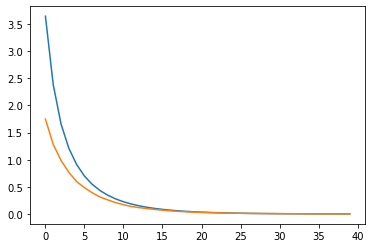

In [47]:
# fitting third order polynomial function fitting

train(poly_features[:n_train, :4], labels[:n_train], poly_features[n_train:, :4], labels[n_train:])

input feature size is : 2
weight :  [[3.1919615 5.425466 ]]


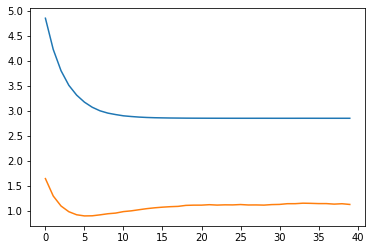

In [48]:
# now trying to underfit

train(poly_features[:n_train, :2], labels[:n_train], poly_features[n_train:, :2], labels[n_train:])

input feature size is : 20
weight :  [[ 4.9376731e+00  1.5284610e+00 -3.1749818e+00  4.6739435e+00
  -5.2845645e-01  8.0622518e-01  4.1620252e-03  5.4121781e-02
  -9.3788557e-02  1.0595342e-01 -1.6730115e-01  1.5583387e-01
   3.7670851e-02  1.5646306e-01  4.6096135e-02  9.8095134e-02
   8.2585402e-02  6.7623489e-02  3.0450003e-02 -1.8183419e-01]]


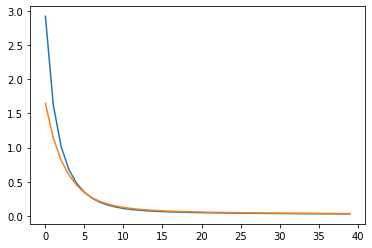

In [49]:
# trying to overfit

train(poly_features[:n_train, :],labels[:n_train], poly_features[n_train:,:], labels[n_train:])

### Exercises

1. Can you solve the polynomial regression problem exactly? Hint: use linear algebra.

dont know

2. Consider model selection for polynomials:
    1. Plot the training loss vs. model complexity (degree of the polynomial). What do you
    observe? What degree of polynomial do you need to reduce the training loss to 0?
    2. Plot the test loss in this case.
    3. Generate the same plot as a function of the amount of data.

3. What happens if you drop the normalization (1/i!) of the polynomial features x
i
? Can you
fix this in some other way?

4. Can you ever expect to see zero generalization error?

In [50]:
#2

def train_loss_vs_model_complexity(t_features, t_labels, te_features, te_labels, num_epochs=20):
    loss = nn.MSELoss()
    
    stored_train_loss = []
    stored_test_loss = []
    stored_len_data = []
    
    for i in range(max_degree):
        train_features = t_features[:, :i+1]
        test_features = te_features[:, :i+1]
        train_labels = t_labels
        test_labels = te_labels
        input_shape = train_features.shape[-1]
        
        amount_of_features = train_features.shape[0] * train_features.shape[1]
        
        print(f"input feature size is : {input_shape}")
        net = nn.Sequential(nn.Linear(input_shape,1, bias=False))
        batch_size = min(10, train_labels.shape[0])
        train_iter = create_iter(train_features, train_labels.reshape(-1,1), batch_size)
        test_iter = create_iter(test_features, test_labels.reshape(-1,1), batch_size)

        optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

        # training loop
        
        for epoch in range(num_epochs):
            for X, y in train_iter:
                y_hat = net(X)
    #             print(y_hat.shape)
    #             print(y, y_hat)
                l = loss(y_hat, y)
                optimizer.zero_grad()
                l.backward()

                optimizer.step()

    #         print(f"Last batch loss for epoch {epoch} is {l.detach()}")
        stored_train_loss.append(evaluate_loss(net, train_iter, loss, "train"))
        stored_test_loss.append(evaluate_loss(net, test_iter, loss, "test"))
        stored_len_data.append(amount_of_features)
#         print("weight : ", net[0].weight.data.numpy(), "\n")
        print(f"train loss : {stored_train_loss[-1]}")
        print(f"test loss: {stored_test_loss[-1]}")
        
    
    plt.plot(range(max_degree), stored_train_loss)
    plt.xlabel("degree")
    plt.ylabel("train loss")
    plt.show()
    
    plt.plot(range(max_degree), stored_test_loss)
    plt.xlabel("degree")
    plt.ylabel("test loss")
    plt.show()
    
    plt.plot(range(max_degree), stored_len_data)
    plt.xlabel("degree")
    plt.ylabel("number of features")
    
    plt.show()

        
    

input feature size is : 1
train loss : 5.805368423461914
test loss: 1.7661118507385254
input feature size is : 2
train loss : 2.8514797687530518
test loss: 1.1240822076797485
input feature size is : 3
train loss : 0.7391793727874756
test loss: 0.2960579991340637
input feature size is : 4
train loss : 0.046619243919849396
test loss: 0.03652077168226242
input feature size is : 5
train loss : 0.02718915231525898
test loss: 0.038509856909513474
input feature size is : 6
train loss : 0.03969020023941994
test loss: 0.05066032335162163
input feature size is : 7
train loss : 0.04128125682473183
test loss: 0.0503634437918663
input feature size is : 8
train loss : 0.044509563595056534
test loss: 0.053561437875032425
input feature size is : 9
train loss : 0.04897398501634598
test loss: 0.05723491683602333
input feature size is : 10
train loss : 0.043725017458200455
test loss: 0.05193492770195007
input feature size is : 11
train loss : 0.04427235201001167
test loss: 0.05392894148826599
input featu

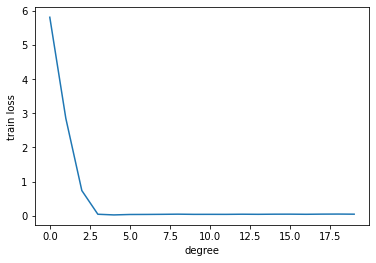

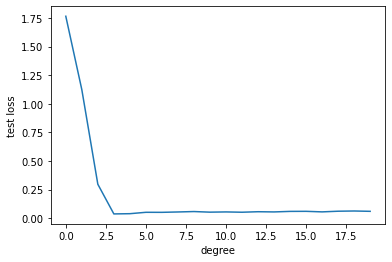

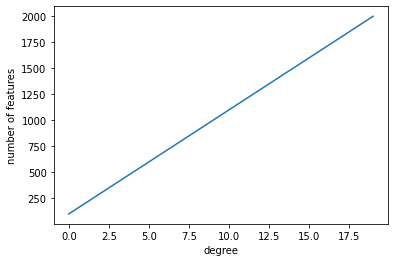

In [51]:
train_loss_vs_model_complexity(poly_features[:n_train, :],labels[:n_train], poly_features[n_train:,:], labels[n_train:])

(200,)
input feature size is : 1
train loss : 107.66314697265625
test loss: 27.702600479125977
input feature size is : 2
train loss : 57.05255889892578
test loss: 13.052611351013184
input feature size is : 3
train loss : 25.509437561035156
test loss: 11.25903606414795
input feature size is : 4
train loss : 15.742505073547363
test loss: 4.3251166343688965
input feature size is : 5
train loss : 59128212.0
test loss: 7288690.0
input feature size is : 6
train loss : inf
test loss: inf
input feature size is : 7
train loss : nan
test loss: nan
input feature size is : 8
train loss : nan
test loss: nan


<ipython-input-54-a71d454ca9c4>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_w,features,new_poly_features, new_labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, new_poly_features, new_labels]]


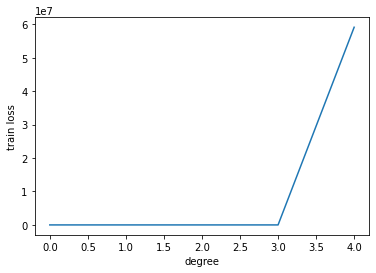

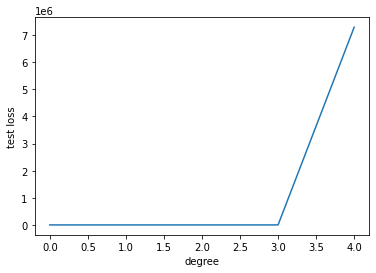

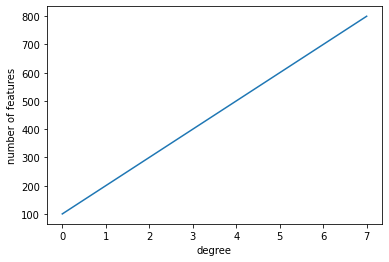

In [54]:
#3

# creating newpoly features without normalisation

new_poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

new_labels = np.dot(new_poly_features, true_w)
print(new_labels.shape)
# adding epsilon noise
new_labels += np.random.normal(scale=0.1, size=new_labels.shape)

true_w,features,new_poly_features, new_labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, new_poly_features, new_labels]]

max_degree=8

train_loss_vs_model_complexity(new_poly_features[:n_train, :],new_labels[:n_train], new_poly_features[n_train:,:], new_labels[n_train:], num_epochs=8)